# Predict Bitcoin price
https://www.kaggle.com/myonin/bitcoin-price-prediction-by-arima/notebook

https://www.kaggle.com/smitad/bitcoin-trading-strategy-simulation

In [1]:
# data wrangling package
library(tidyverse)
# time series objects
library(xts)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ dplyr   1.0.7
✔ tidyr   1.1.4     ✔ stringr 1.4.0
✔ readr   2.1.0     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Loading required package: zoo


Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric



Attaching package: ‘xts’


The following objects are masked from ‘package:dplyr’:

    first, last




In [2]:
# Get data using API
library("quantmod")
getSymbols("BTC-USD")
df <- `BTC-USD`
summary(df)

Loading required package: TTR

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 

‘getSymbols’ currently uses auto.assign=TRUE by default, but will
use auto.assign=FALSE in 0.5-0. You will still be able to use
‘loadSymbols’ to automatically load data. getOption("getSymbols.env")
and getOption("getSymbols.auto.assign") will still be checked for
alternate defaults.

This message is shown once per session and may be disabled by setting 
options("getSymbols.warning4.0"=FALSE). See ?getSymbols for details.


Warning message:
“BTC-USD contains missing values. Some functions will not work if objects contain missing values in the middle of the series. Consider using na.omit(), na.approx(), na.fill(), etc to remove or replace them.”


[1] "BTC-USD"

     Index             BTC-USD.Open      BTC-USD.High      BTC-USD.Low     
 Min.   :2014-09-17   Min.   :  176.9   Min.   :  211.7   Min.   :  171.5  
 1st Qu.:2016-07-08   1st Qu.:  587.5   1st Qu.:  592.0   1st Qu.:  581.1  
 Median :2018-04-30   Median : 5925.5   Median : 6180.0   Median : 5732.5  
 Mean   :2018-04-30   Mean   :10459.4   Mean   :10747.9   Mean   :10143.0  
 3rd Qu.:2020-02-19   3rd Qu.:10111.9   3rd Qu.:10292.2   3rd Qu.: 9732.6  
 Max.   :2021-12-11   Max.   :67549.7   Max.   :68789.6   Max.   :66382.1  
                      NA's   :4         NA's   :4         NA's   :4        
 BTC-USD.Close     BTC-USD.Volume      BTC-USD.Adjusted 
 Min.   :  178.1   Min.   :5.915e+06   Min.   :  178.1  
 1st Qu.:  587.8   1st Qu.:7.591e+07   1st Qu.:  587.8  
 Median : 5930.3   Median :4.788e+09   Median : 5930.3  
 Mean   :10475.8   Mean   :1.419e+10   Mean   :10475.8  
 3rd Qu.:10116.3   3rd Qu.:2.338e+10   3rd Qu.:10116.3  
 Max.   :67566.8   Max.   :3.510e+11   Max.   :675

Here we get 6 values:
I am going to predict the price using the adjusted price. Adjusted price is usually used for backtesting, as it reflects the value for any corporate actions. It is mostly used for analysis.

Looks like there are 4 missing values. Lets take a look at it and the data points around them and see that to do with them.

In [3]:
df <- Ad(df)
colnames(df) <- "Price"
which(rowSums(is.na(df)) != 0)
df[rowSums(is.na(df)) != 0, ]

[1] 2040 2215 2218 2219

           Price
2020-04-17    NA
2020-10-09    NA
2020-10-12    NA
2020-10-13    NA

Lets have a look around the those (April 10th to 20th) and (October 10th to 20th):

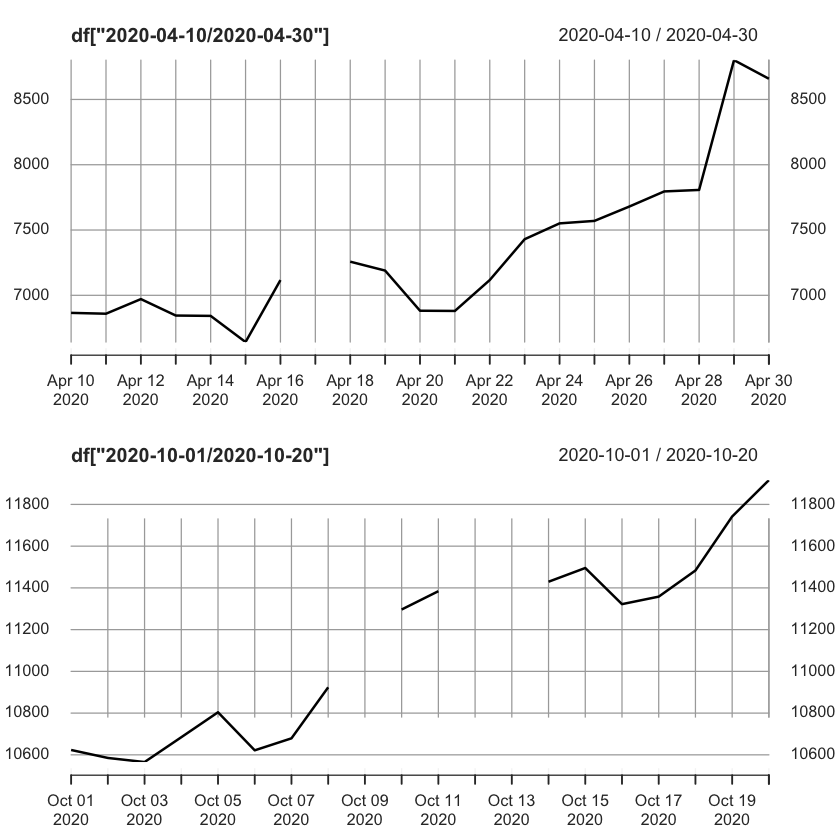

In [4]:
# plot the periods
par(mfrow = c(2, 1))
plot(df["2020-04-10/2020-04-30"], type = "l", col = "black")
plot(df["2020-10-01/2020-10-20"], type = "l", col = "black")

Here I have decided to fill the NAs with linear approximation.

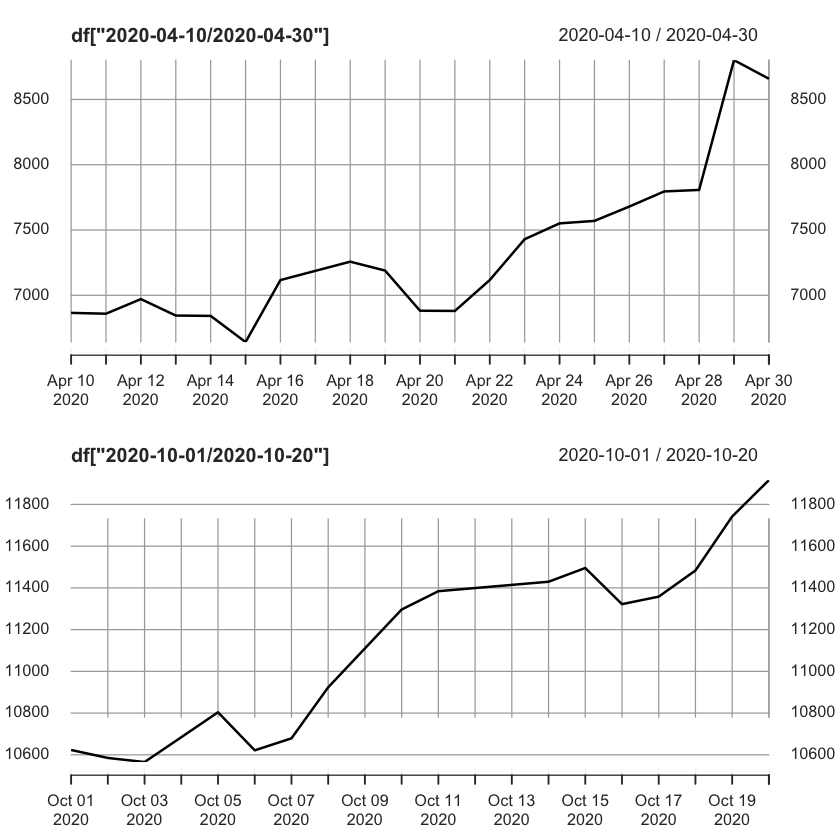

In [5]:
# fill NAs with linear approximation
df <- na.approx(df)

# plot the periods
par(mfrow = c(2, 1))
plot(df["2020-04-10/2020-04-30"], type = "l", col = "black")
plot(df["2020-10-01/2020-10-20"], type = "l", col = "black")

Looks nice. Next I am going to plot the price to have an inital view.

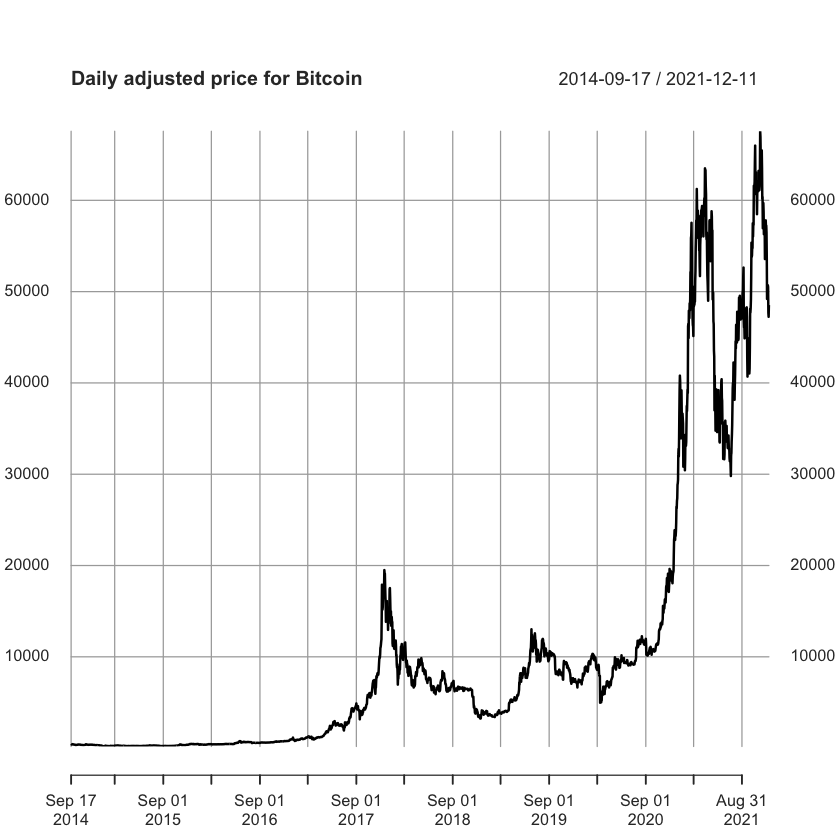

In [6]:
plot(df, col = "black", main = "Daily adjusted price for Bitcoin")

Try sampling monthly, quarterly and yearly to see if there is a pattern.

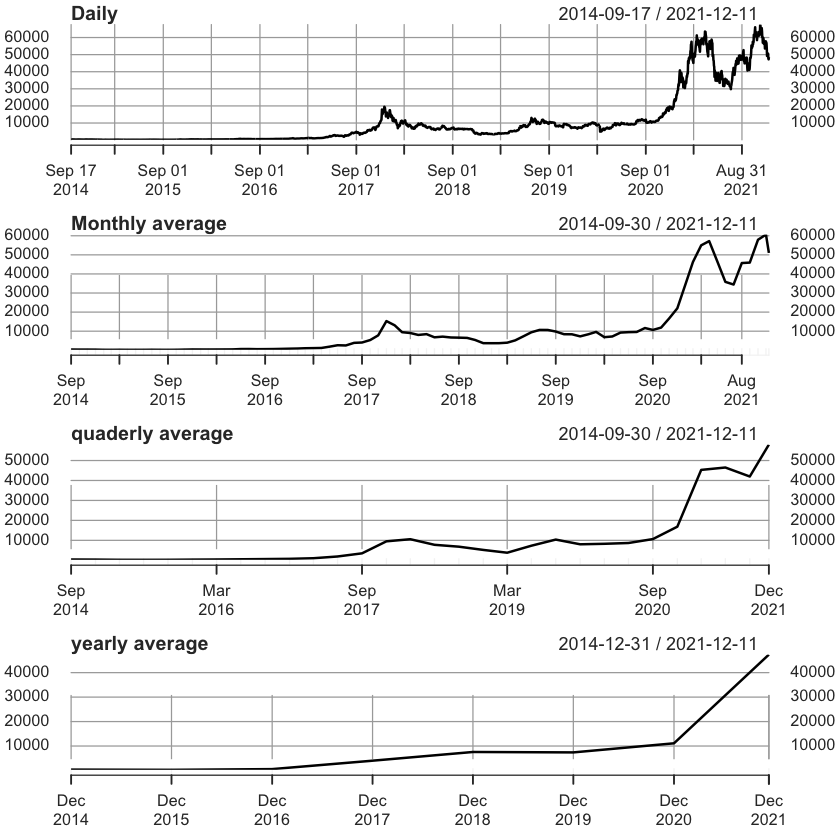

In [8]:
# 4 plots in one
par(mfrow=c(4, 1))

# turn the data to a xts object
plot(df, main = "Daily")

# monlthy
df_monthly <- apply.monthly(df, mean)
plot(df_monthly, main = "Monthly average")

# quad yearly
df_quaderly <- apply.quarterly(df, mean)
plot(df_quaderly, main = "quaderly average")

# yearly
df_yearly <- apply.yearly(df, mean)
plot(df_yearly, main = "yearly average")

Daily data fluctuates too much, quaderly and yearly has too little movement. Therefore I will use the the monthly average data instead.

Variance fluctuates. Take a log to reduce varience 

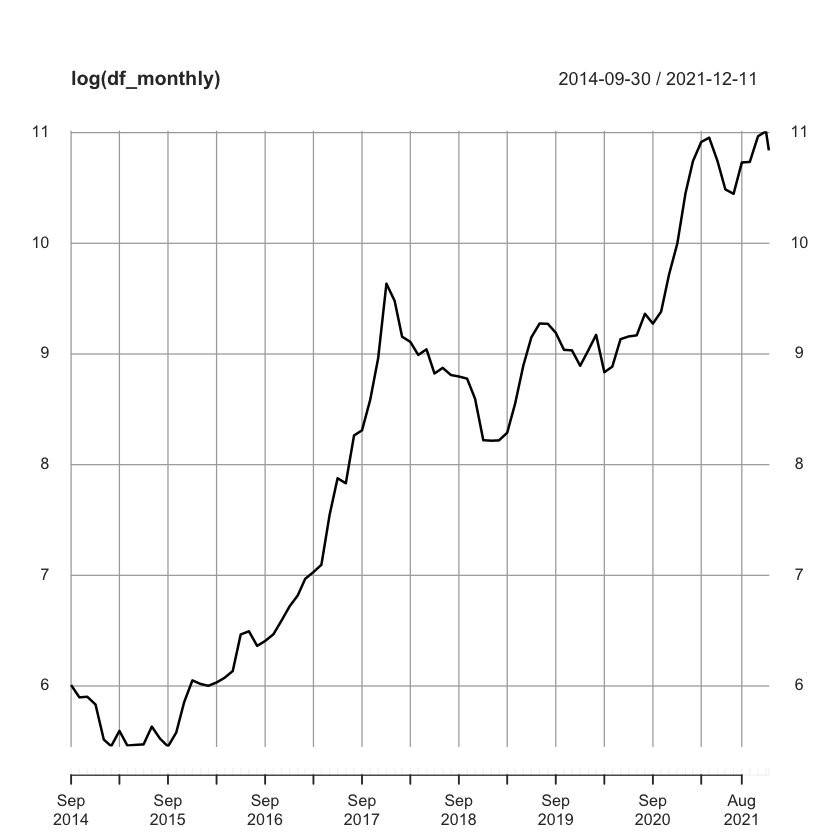

In [9]:
plot(log(df_monthly))

The variance looks a bit more stationary. There is an obvious upward trend. 